# Assignment 7 - Optimization Methods
## Matteo Ghilardini
---

### Part 3: programming problem

#### Setup the environment:

Install the required libraries in the jupiter notebook environment:

In [229]:
pip install numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Import all the required libraries

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

#### **Problem 1** (Basic solutions and reduced costs)

##### 1.

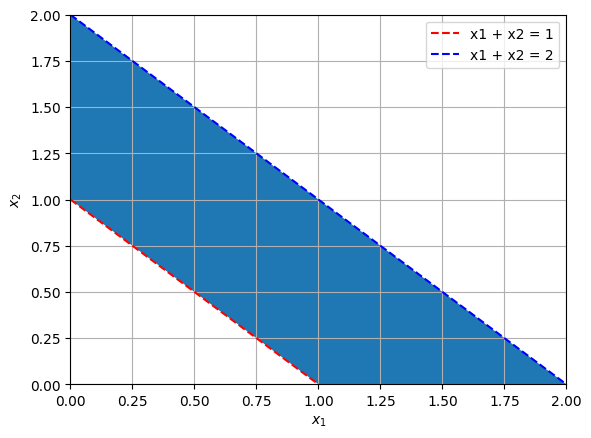

In [231]:
x1_vals = np.linspace(0, 2, 500)

x2_lower = np.maximum(1 - x1_vals, 0)
x2_upper = 2 - x1_vals

plt.plot(x1_vals, 1 - x1_vals, 'r--', label='x1 + x2 = 1')
plt.plot(x1_vals, 2 - x1_vals, 'b--', label='x1 + x2 = 2')
plt.fill_between(x1_vals, x2_lower, x2_upper, where=(x2_upper >= x2_lower))

plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.grid()
plt.show()

##### 2.


Introduce a surplus variable $x_3 \geq 0$ for the first inequality and a slack variable  $x_4 \geq 0$ for the second inequality:

$$
\begin{aligned}
x_1 + x_2 - x_3       &= 1 \\
x_1 + x_2 + x_4       &= 2 \\
x_1, x_2, x_3, x_4 &\geq 0
\end{aligned}
$$

And so in the standard form \( Ax = b \), we have:
$$
A = \begin{bmatrix}
1 & 1 & -1 & 0 \\
1 & 1 &  0 & 1
\end{bmatrix}, \;

b = \begin{bmatrix}
1 \\
2
\end{bmatrix}
$$

with 2 constrains (plus the inequality one).

In [232]:
A = np.array([
    [1, 1, -1, 0],
    [1, 1,  0, 1]
])

b = np.array([1, 2])
m = A.shape[0]

print("A =\n", A)
print("b =", b)
print("m =", m)

A =
 [[ 1  1 -1  0]
 [ 1  1  0  1]]
b = [1 2]
m = 2


##### 3.

In [233]:
def extract_basis_matrix(A, basic_indices):
    zero_based_indices = [bi - 1 for bi in basic_indices]  # Convert to zero-based index
    return A[:, zero_based_indices]

basic_indices = [3,4]
B1 = extract_basis_matrix(A, basic_indices)

print("B1 =", B1)


B1 = [[-1  0]
 [ 0  1]]


##### 4.

In [234]:
def basic_variables(B, b):
    try:
        xB = np.linalg.solve(B, b)
        return xB
    except np.linalg.LinAlgError:
        return None

xB1 = basic_variables(B1, b)

print("xB1 =", xB1)

xB1 = [-1.  2.]


##### 5.

In [235]:
def is_feasible(xB):
    return np.all(xB >= 0)

def is_degenerate(xB):
    return np.any(np.isclose(xB, 0.0))

print("Is xB1 feasible?", is_feasible(xB1))
print("Is xB1 degenerate?", is_degenerate(xB1))

Is xB1 feasible? False
Is xB1 degenerate? False


##### 6.

In [236]:
def full_basic_solution(n, xB, basic_indices):
    x = np.zeros(n)
    for val, idx in zip(xB, basic_indices):
        x[idx - 1] = val  # Convert to 0-based indexing
    return x

n = A.shape[1] # Get the number of variables
x_full = full_basic_solution(n, xB1, basic_indices)

print("Full basic solution x =", x_full)


Full basic solution x = [ 0.  0. -1.  2.]


##### 7.

In [237]:
def construct_basic_solution(A, b, basic_indices):
    B = extract_basis_matrix(A, basic_indices)
    xB = basic_variables(B, b)
    if xB is None:
        return None, False, False
    
    n = A.shape[1]
    x = full_basic_solution(n, xB, basic_indices)
    feasible = is_feasible(xB)
    degenerate = is_degenerate(xB)
    return x, feasible, degenerate

x_result, feasible, degenerate = construct_basic_solution(A, b, [3, 4])

print("Basic solution x =", x_result)
print("Feasible?", feasible)
print("Degenerate?", degenerate)


Basic solution x = [ 0.  0. -1.  2.]
Feasible? False
Degenerate? False


##### 8.

In [238]:

n = A.shape[1]  # Total number of variables
m = A.shape[0]  # Number of constraints

basic_feasible_count = 0
degenerate_count = 0

print("All basic solutions:")

for indices in combinations(range(1, n + 1), m):  # 1-based indexing
    x, feasible, degenerate = construct_basic_solution(A, b, list(indices))
    print(f"indices = {indices}, x = {x}, feasible = {feasible}, degenerate = {degenerate}")
    
    if feasible:
        basic_feasible_count += 1
        if degenerate:
            degenerate_count += 1

print("Total basic feasible solutions:", basic_feasible_count)
print("Degenerate basic feasible solutions:", degenerate_count)

All basic solutions:
indices = (1, 2), x = None, feasible = False, degenerate = False
indices = (1, 3), x = [2. 0. 1. 0.], feasible = True, degenerate = False
indices = (1, 4), x = [1. 0. 0. 1.], feasible = True, degenerate = False
indices = (2, 3), x = [0. 2. 1. 0.], feasible = True, degenerate = False
indices = (2, 4), x = [0. 1. 0. 1.], feasible = True, degenerate = False
indices = (3, 4), x = [ 0.  0. -1.  2.], feasible = False, degenerate = False
Total basic feasible solutions: 4
Degenerate basic feasible solutions: 0


##### 9.

In [239]:
def reduced_costs(A, c, basic_indices):
    B = A[:, basic_indices]
    try:
        B_inv = np.linalg.inv(B)
    except np.linalg.LinAlgError:
        return None, False

    cB = c[basic_indices]
    c_bar = np.zeros_like(c, dtype=float)

    for j in range(len(c)):
        Aj = A[:, j]
        c_bar[j] = c[j] - cB @ (B_inv @ Aj)

    is_optimal = np.all(c_bar >= -1e-8)
    return c_bar, is_optimal

c = np.array([1, 1, 0, 0])
basic_indices = [0, 3]  # Are already zero-based indices, meaning x_1 and x_4

c_bar, is_opt = reduced_costs(A, c, basic_indices)
print("Reduced costs:", c_bar)
print("Is optimal basis?", is_opt)


Reduced costs: [0. 0. 1. 0.]
Is optimal basis? True


##### 10.

In [240]:
best_cost = float('inf')
best_solution = None
best_indices = None

c = np.array([1, 1, 0, 0])  # Given cost vector

print("Evaluating all basic feasible solutions:\n")

for indices in combinations(range(1, n + 1), m):  # 1-based indices
    x, feasible, degenerate = construct_basic_solution(A, b, list(indices))
    if feasible:
        cost = c @ x
        print("indices =",indices,"\tx =",x, "\tcost =",  cost)
        if cost < best_cost:
            best_cost = cost
            best_solution = x
            best_indices = indices

print("Optimal basic feasible solution:")
print("\tIndices:", best_indices)
print("\tx_opt =", best_solution)
print("\tOptimal cost =", best_cost)


Evaluating all basic feasible solutions:

indices = (1, 3) 	x = [2. 0. 1. 0.] 	cost = 2.0
indices = (1, 4) 	x = [1. 0. 0. 1.] 	cost = 1.0
indices = (2, 3) 	x = [0. 2. 1. 0.] 	cost = 2.0
indices = (2, 4) 	x = [0. 1. 0. 1.] 	cost = 1.0
Optimal basic feasible solution:
	Indices: (1, 4)
	x_opt = [1. 0. 0. 1.]
	Optimal cost = 1.0


#### **Problem 2** (Simplex algorithm)

##### 1.

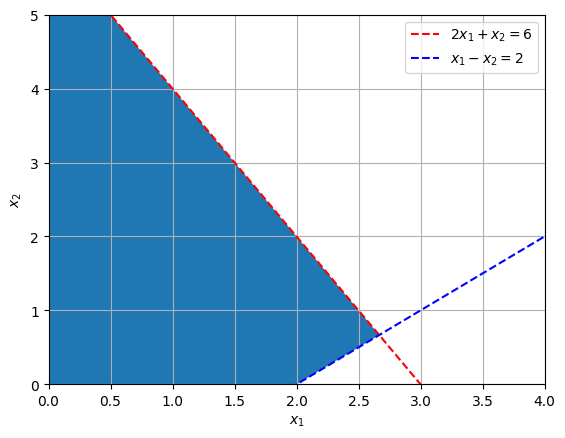

In [241]:
x1_vals = np.linspace(0, 4, 500)

x2_1 = 6 - 2 * x1_vals
x2_2 = x1_vals - 2

x2_lower = np.maximum(0, x1_vals - 2)
x2_upper = np.minimum(6 - 2 * x1_vals, np.full_like(x1_vals, np.inf))

plt.plot(x1_vals, 6 - 2 * x1_vals, 'r--', label=r'$2x_1 + x_2 = 6$')
plt.plot(x1_vals, x1_vals - 2, 'b--', label=r'$x_1 - x_2 = 2$')
plt.fill_between(x1_vals, x2_lower, x2_upper, where=(x2_upper >= x2_lower))

# Formatting
plt.xlim(0, 4)
plt.ylim(0, 5)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.grid()
plt.show()

##### 2.

Introduce a slack variable $x_3 \geq 0$ for the first inequality and a slack variable $x_4 \geq 0$ for the second inequality:

$$
\begin{aligned}
2x_1 + x_2 + x_3 &= 6 \\
x_1 - x_2 + x_4 &= 2 \\
x_1, x_2, x_3, x_4 &\geq 0
\end{aligned}
$$

And so in the standard form \( Ax = b \), we have:

$$
A = \begin{bmatrix}
2 & 1 & 1 & 0 \\
1 & -1 & 0 & 1
\end{bmatrix}, \;
b = \begin{bmatrix}
6 \\
2
\end{bmatrix}, \;
c = \begin{bmatrix}
-4 \\
3 \\
0 \\
0
\end{bmatrix}
$$

In [242]:
A = np.array([
    [2, 1, 1, 0],
    [1, -1, 0, 1]
])

b = np.array([6, 2])

c = np.array([-4, 3, 0, 0])

##### 3.

In [243]:
basic_indices = [0,3]

# Compute the initial basic solution
x0, feasible, degenerate = construct_basic_solution(A, b, basic_indices)

print("Initial basic solution x0 =", x0)
print("Feasible?", feasible)
print("Degenerate?", degenerate)

Initial basic solution x0 = [0. 0. 6. 2.]
Feasible? True
Degenerate? False


##### 4.

In [244]:
def index_entering_basis(A, c, basic_indices):
    c_bar, _ = reduced_costs(A, c, [i - 1 for i in basic_indices])
    print("Reduced cost vector:", c_bar)
    basic_set = set(i - 1 for i in basic_indices)
    non_basic = [i for i in range(len(c)) if i not in basic_set]

    for j in sorted(non_basic):
        if c_bar[j] < 0:
            return j
    print("Current basis is optimal. No entering index found.")
    return None

j = index_entering_basis(A, c, basic_indices)

if j is not None:
    print("Entering index j =", j)
    c_bar, _ = reduced_costs(A, c, [i - 1 for i in basic_indices])
    print("Reduced cost at j:", c_bar[j])


Reduced cost vector: [-4.  3.  0.  0.]
Entering index j = 0
Reduced cost at j: -4.0


##### 5.

In [245]:
def basic_direction(A, basic_indices, j):
    n = A.shape[1]
    B = A[:, basic_indices]
    try:
        B_inv = np.linalg.inv(B)
    except np.linalg.LinAlgError:
        return None

    A_j = A[:, j]
    d_B = B_inv @ A_j

    d = np.zeros(n)
    d[j] = 1.0
    for val, bi in zip(d_B, basic_indices):
        d[bi] = -val
    return d

d = basic_direction(A, basic_indices, j)
print("Basic direction d =", d)


Basic direction d = [-1.  0.  0. -0.]


##### 6.

In [246]:
def longest_step(x, d):
    theta = float('inf')
    leaving_index = None
    
    for i in range(len(x)):
        if d[i] < 0:
            step = -x[i] / d[i]
            if step < theta or (np.isclose(step, theta) and (leaving_index is None or i < leaving_index)):
                theta = step
                leaving_index = i

    if theta == float('inf'):
        print("This problem is unbounded.")
        return float('inf'), None

    return theta, leaving_index


theta, leaving_index = longest_step(x0, d)

print("Direction d =", d)
print("theta:", theta)
print("Leaving index:", leaving_index)


Direction d = [-1.  0.  0. -0.]
theta: 0.0
Leaving index: 0


##### 7.

In [247]:
def simplex_iteration(A, c, b, basic_indices):
    entering_index = index_entering_basis(A, c, [i + 1 for i in basic_indices])
    if entering_index is None:
        print("Optimal basis reached.")
        return basic_indices

    d = basic_direction(A, basic_indices, entering_index)
    if d is None:
        print("Singular basis matrix.")
        return None

    x, feasible, _ = construct_basic_solution(A, b, [i + 1 for i in basic_indices])
    if not feasible:
        print("Infeasible solution encountered.")
        return None

    theta, leaving_index = longest_step(x, d)
    if leaving_index is None:
        print("This problem is unbounded.")
        return None

    new_basic_indices = basic_indices.copy()
    new_basic_indices[leaving_index] = entering_index
    return new_basic_indices


##### 8.

In [248]:
for iteration in range(3):
    print("--- Iteration",iteration," ---")
    new_basic_indices = simplex_iteration(A, c, b, basic_indices)
    
    if new_basic_indices is None:
        print("The problem is unbounded.")
        break
    elif new_basic_indices == basic_indices:
        print("Optimal basis reached.")
        break
    else:
        basic_indices = new_basic_indices
        print("Updated basic indices:", basic_indices)

# Final solution and cost
x_opt, feasible, _ = construct_basic_solution(A, b, [i + 1 for i in basic_indices])
cost_opt = c @ x_opt

print("\nOptimal solution x* =", x_opt)
print("Optimal cost c^T x* =", cost_opt)

--- Iteration 0  ---
Reduced cost vector: [0. 5. 2. 0.]
Current basis is optimal. No entering index found.
Optimal basis reached.
Optimal basis reached.

Optimal solution x* = [ 3.  0.  0. -1.]
Optimal cost c^T x* = -12.0
